In [92]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fahmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [70]:
df = pd.read_csv('vaccination_tweets.csv')
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10341 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [72]:
df.isnull().sum()

id                     0
user_name              0
user_location       2270
user_description     679
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [73]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [74]:
text_df = df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'], axis=1)
text_df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [75]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm 

#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P 

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4 

Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq 



#### Text proses atau pembersihan text

In [76]:
def data_proses(text):
    text = text.lower()
    text = re.sub(r'https\S+|www\S+https\S+','',text, flags=re.MULTILINE) # Untuk membuang link disebelah text
    text = re.sub(r'\@w+|\#','',text) # Untuk membuang simbol pada text
    text = re.sub(r'[^\w\s]','',text)
    text_token = word_tokenize(text)
    filter_text = [w for w in text_token if not w in stop_words]
    return " ".join(filter_text)

In [77]:
text_df.text = text_df['text'].apply(data_proses)

In [78]:
text_df = text_df.drop_duplicates('text')

In [79]:
stemmer = PorterStemmer()
def steaming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [80]:
# Untuk mematikan peringatan pada cell dibawwah
# pd.options.mode.chained_assignment = None 

In [81]:
text_df['text'] = text_df['text'].apply(lambda x: steaming(x))

In [82]:
text_df

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...
...,...
11014,ruvanw gmalavige chandi2012 already 3rd pfizer...
11015,number covid19 cases today 17 november 2021 re...
11017,number covid19 cases today 16 november 2021 re...
11018,pfizerbiontech developed new pill paxlovid inc...


In [83]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

folks said daikon paste could treat cytokine storm pfizerbiontech 

world wrong side history year hopefully biggest vaccination effort weve ev 

coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_19 russian vaccine created last 24 years 

facts immutable senator even youre ethically sturdy enough acknowledge 1 born 

explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech 



In [84]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10543 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10543 non-null  object
dtypes: object(1)
memory usage: 164.7+ KB


#### Melabeli text menggunakan TextBlob

In [85]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [86]:
text_df['polarity'] = text_df['text'].apply(polarity)

In [87]:
text_df.head(5)

,text,polarity
0,folks said daikon paste could treat cytokine s...,0.0
1,world wrong side history year hopefully bigges...,-0.5
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0
3,facts immutable senator even youre ethically s...,0.1
4,explain need vaccine borisjohnson matthancock ...,0.0


In [88]:
def sentiment(label):
    if label < 0:
        return 'Negative'
    elif label == 0:
        return 'Neutral'
    else:
        return 'Positif'

In [89]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)

In [91]:
text_df.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
3,facts immutable senator even youre ethically s...,0.1,Positif
4,explain need vaccine borisjohnson matthancock ...,0.0,Neutral


<AxesSubplot:xlabel='sentiment', ylabel='count'>

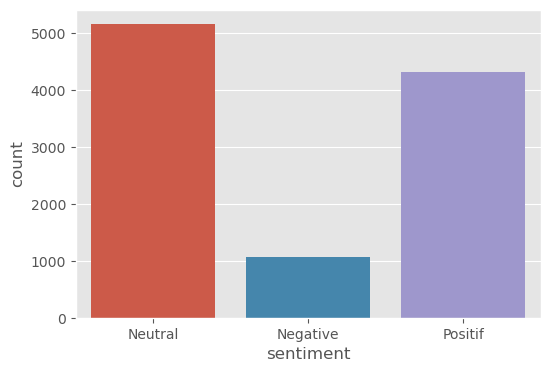

In [93]:
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment',data=text_df)

Text(0.5, 1.0, 'Distribusi sentiment')

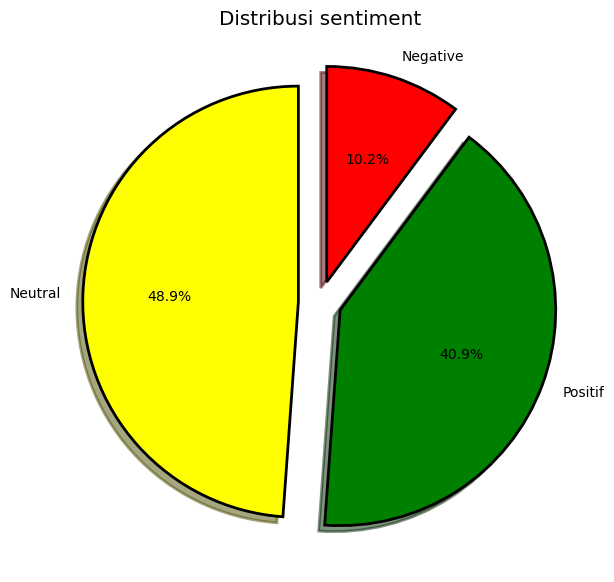

In [95]:
fig = plt.figure(figsize=(7,7))
colors = ('yellow', 'green', 'red')
wp = {'linewidth':2, 'edgecolor':'black'}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors,
          startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title('Distribusi sentiment')

#### Mencari kata 'Positive' Terpopuler 

In [114]:
pos_tweet = text_df[text_df['sentiment']=='Positif'].sort_values(['polarity'], ascending=False)
pos_tweet.head()

,text,polarity,sentiment
9317,best way get merrygoround pfizer pfizerbiontec...,1.0,Positif
2340,applying emotion pfizerbiontech based best evi...,1.0,Positif
6295,pfizer jab morning efficient wellorganised tha...,1.0,Positif
5041,get art printed awesome products support redbu...,1.0,Positif
1055,already vaccinated getting vaccine soon plan t...,1.0,Positif


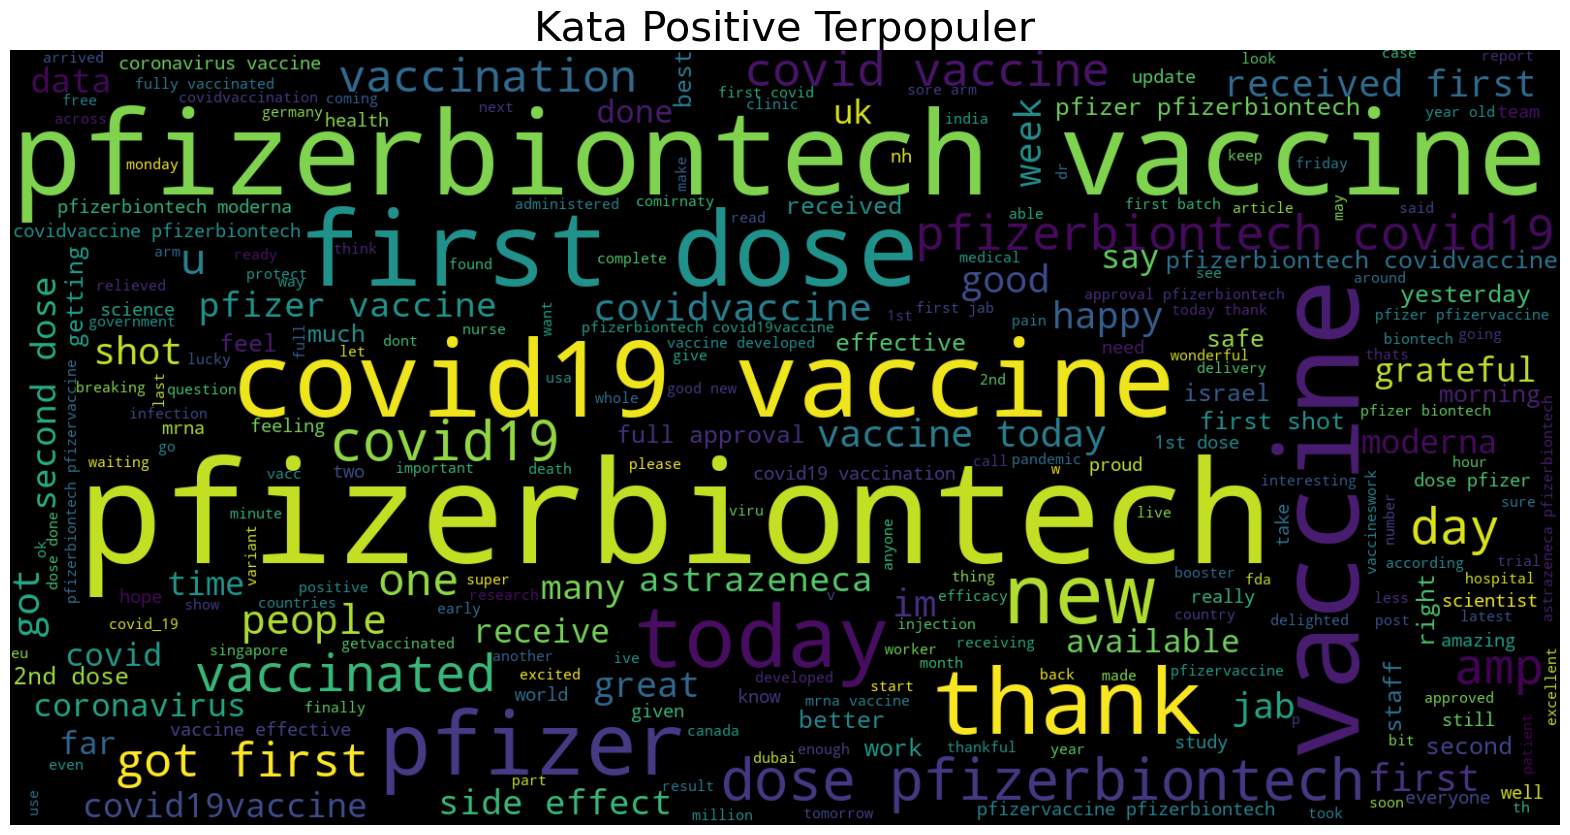

In [120]:
text = ' '.join([word for word in pos_tweet['text']])
plt.figure(figsize=(20,15), facecolor='None')
worlcloud = WordCloud(width=1600, height=800, max_words=250).generate(text)
plt.imshow(worlcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Kata Positive Terpopuler', fontsize=30);

#### Mencari kata 'Neutral' Terpopuler

In [115]:
neutral_tweet = text_df[text_df['sentiment']=='Neutral'].sort_values(['polarity'], ascending=False)
neutral_tweet.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
7347,anyone else feel like framing vaccine card pfi...,0.0,Neutral
7458,looking forward getting second pfizer shot any...,0.0,Neutral
7454,never thought id running diff vaccine modernav...,0.0,Neutral
7453,john___m dont get choose one person know asked...,0.0,Neutral


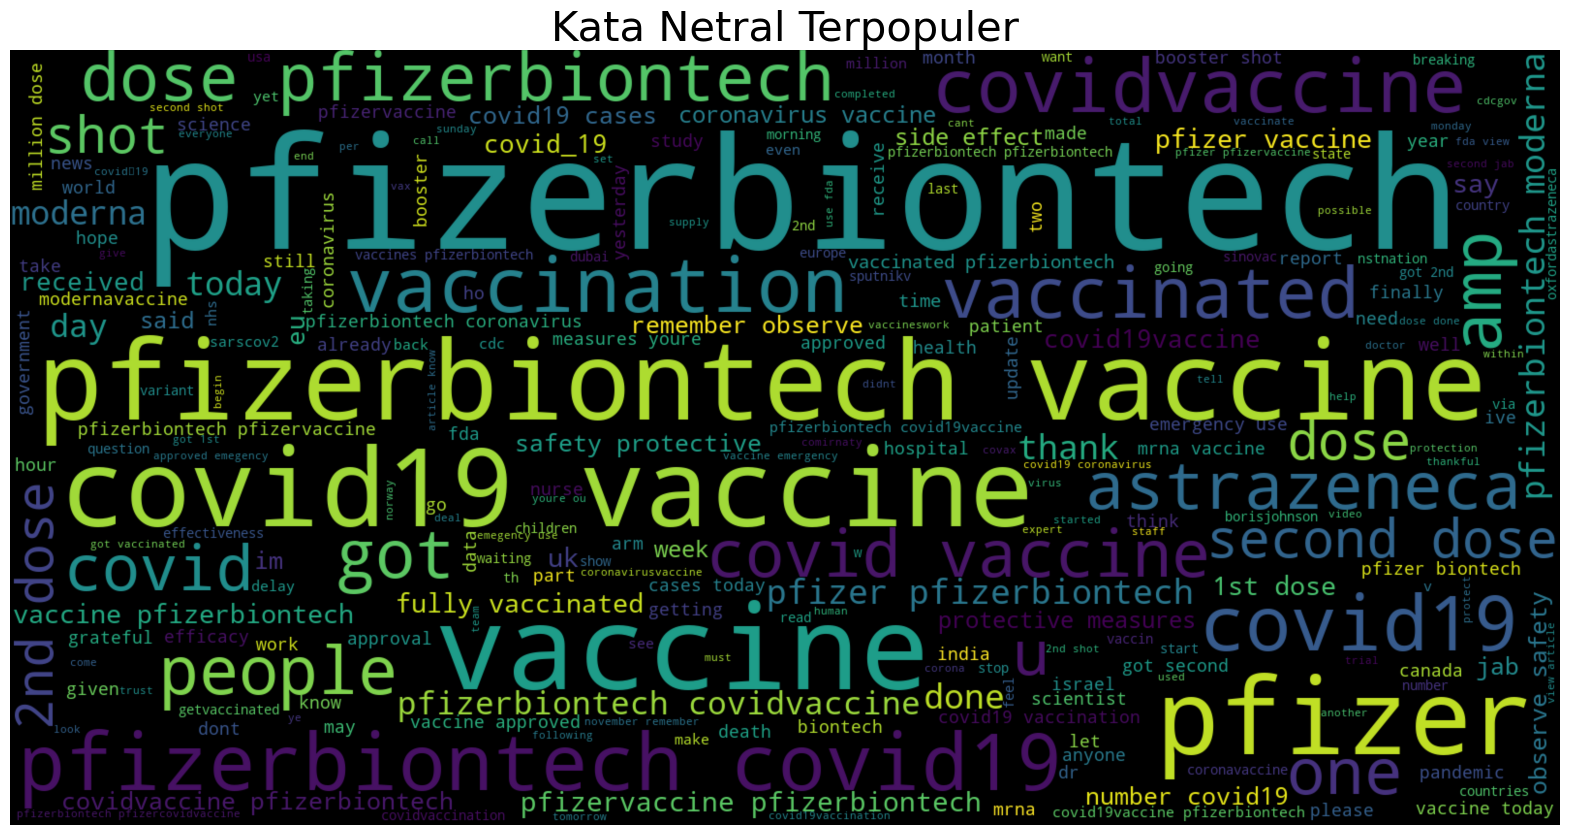

In [121]:
text = ' '.join([word for word in neutral_tweet['text']])
plt.figure(figsize=(20,15), facecolor='None')
worlcloud = WordCloud(width=1600, height=800, max_words=250).generate(text)
plt.imshow(worlcloud, interpolation='gaussian')
plt.axis('off')
plt.title('Kata Netral Terpopuler', fontsize=30);

#### Mencari kata 'Negative' Terpopuler

In [116]:
neg_tweet = text_df[text_df['sentiment']=='Negative'].sort_values(['polarity'], ascending=False)
neg_tweet.head()

,text,polarity,sentiment
2912,work skilled nursing facility got first vaccin...,-0.003333,Negative
7256,200321 752308 vaccinations new daily record da...,-0.003409,Negative
2073,ukgovernment cant even vaccinate properly ethi...,-0.004762,Negative
7715,got first dose less waiting time airport vacci...,-0.005556,Negative
7157,nas_k27 second dose due end next month well fa...,-0.006250,Negative


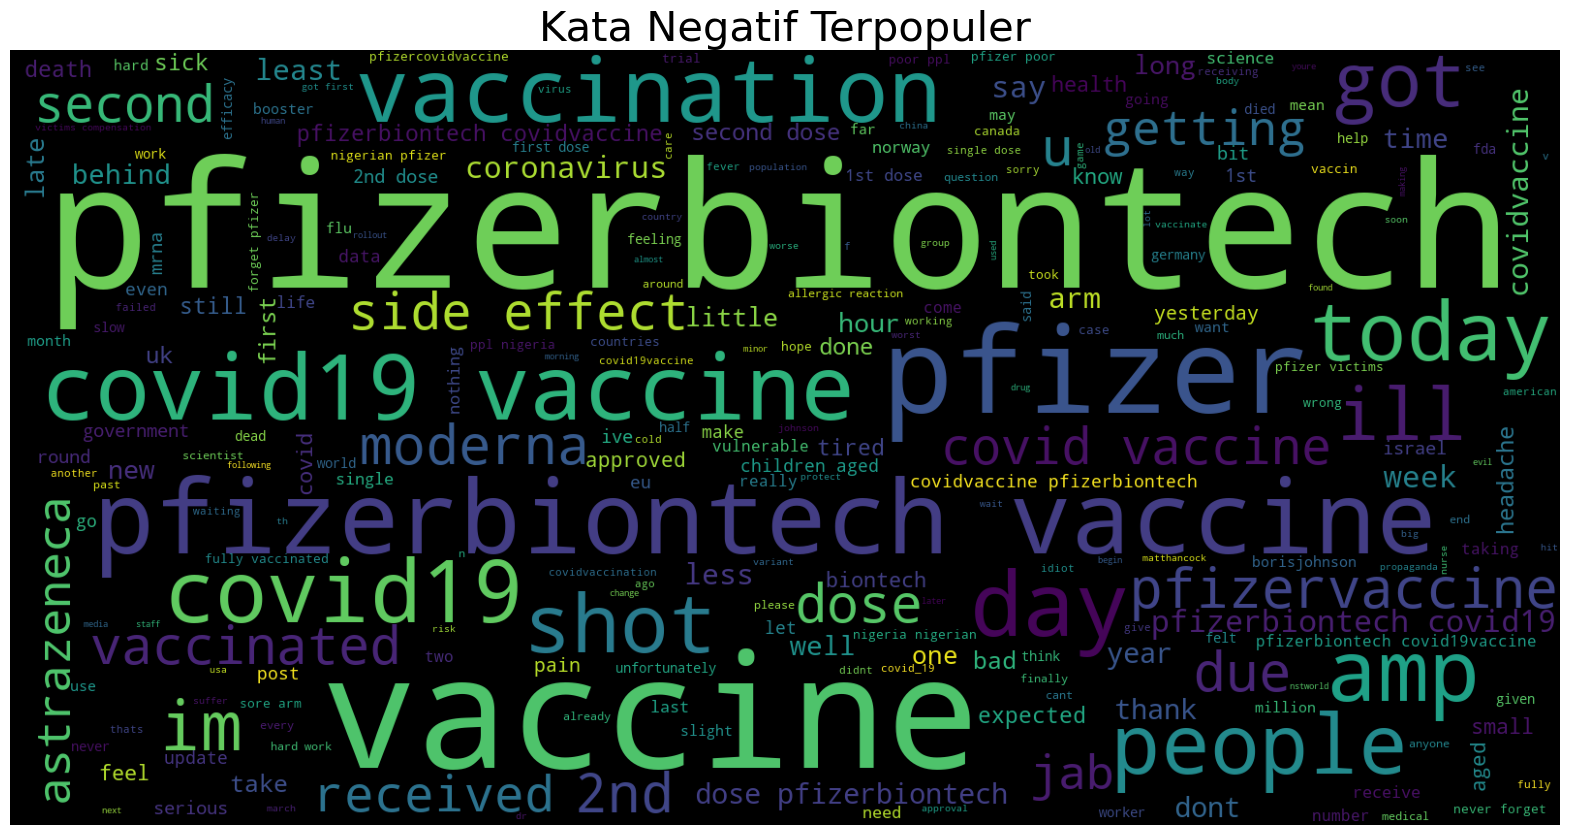

In [122]:
text = ' '.join([word for word in neg_tweet['text']])
plt.figure(figsize=(20,15), facecolor='None')
worlcloud = WordCloud(width=1600, height=800, max_words=250).generate(text)
plt.imshow(worlcloud, interpolation='kaiser')
plt.axis('off')
plt.title('Kata Negatif Terpopuler', fontsize=30);

#### Menggunakan CountVectorize

In [130]:
import warnings
warnings.filterwarnings('ignore')

In [123]:
X = text_df['text']
y = text_df['sentiment']

In [124]:
cv = CountVectorizer(ngram_range=(1,2))

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [126]:
cv.fit(X_train)

CountVectorizer(ngram_range=(1, 2))

In [127]:
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [131]:
feature_names = cv.get_feature_names()
print(f'Jumlah Fitur : {len(feature_names)}')

Jumlah Fitur : 65513


In [128]:
print("Size of x_train:", (X_train_cv.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (X_test_cv.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (8434, 65513)
Size of y_train: (8434,)
Size of x_test: (2109, 65513)
Size of y_test: (2109,)


In [136]:
from sklearn.metrics import accuracy_score

In [139]:
def run_model(model):
    model.fit(X_train_cv,y_train)
    y_pred = model.predict(X_test_cv)
    acc = accuracy_score(y_pred, y_test)
    print(f'Test Akurasi : {acc}')
    print(classification_report(y_test, y_pred))
    
    style.use('classic')
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot();

LogisticR Model
Test Akurasi : 0.8553816974869607
              precision    recall  f1-score   support

    Negative       0.83      0.36      0.50       199
     Neutral       0.80      0.99      0.88      1029
     Positif       0.96      0.81      0.88       881

    accuracy                           0.86      2109
   macro avg       0.86      0.72      0.75      2109
weighted avg       0.87      0.86      0.84      2109



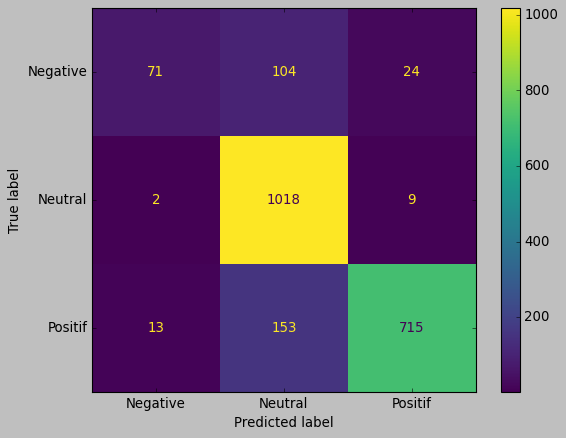

In [140]:
print('LogisticR Model')
lr_model = LogisticRegression()
run_model(lr_model)

Linear SVC model
Test Akurasi : 0.8790896159317212
              precision    recall  f1-score   support

    Negative       0.81      0.45      0.58       199
     Neutral       0.83      0.99      0.90      1029
     Positif       0.96      0.85      0.90       881

    accuracy                           0.88      2109
   macro avg       0.87      0.76      0.80      2109
weighted avg       0.88      0.88      0.87      2109



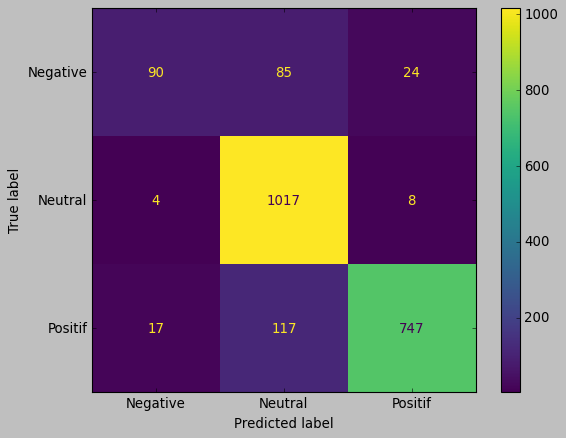

In [141]:
print('Linear SVC model')
svc_model = LinearSVC()
run_model(svc_model)

#### Menggunakan TFidfVectorize

In [142]:
tfidf = TfidfVectorizer()

In [143]:
tfidf.fit(X_train)

TfidfVectorizer()

In [144]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [145]:
def run_model2(model):
    model.fit(X_train_tfidf,y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_pred, y_test)
    print(f'Test Akurasi : {acc}')
    print(classification_report(y_test, y_pred))
    
    style.use('classic')
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot();

Linear SVC model
Test Akurasi : 0.9046941678520626
              precision    recall  f1-score   support

    Negative       0.82      0.56      0.66       199
     Neutral       0.88      0.98      0.93      1029
     Positif       0.96      0.89      0.92       881

    accuracy                           0.90      2109
   macro avg       0.89      0.81      0.84      2109
weighted avg       0.91      0.90      0.90      2109



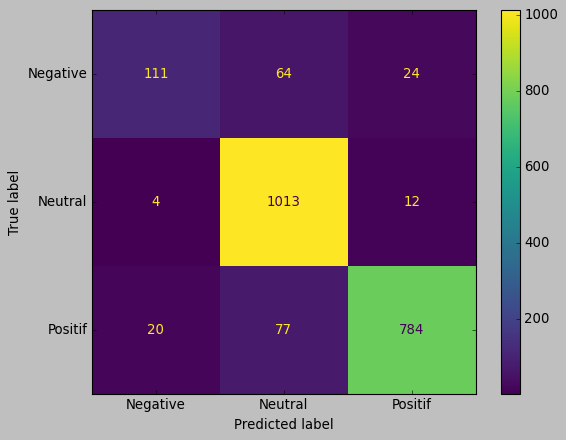

In [146]:
print('Linear SVC model')
svc_model = LinearSVC()
run_model2(svc_model)

LogisticR Model
Test Akurasi : 0.8468468468468469
              precision    recall  f1-score   support

    Negative       0.83      0.23      0.36       199
     Neutral       0.79      0.99      0.88      1029
     Positif       0.94      0.82      0.88       881

    accuracy                           0.85      2109
   macro avg       0.85      0.68      0.70      2109
weighted avg       0.86      0.85      0.83      2109



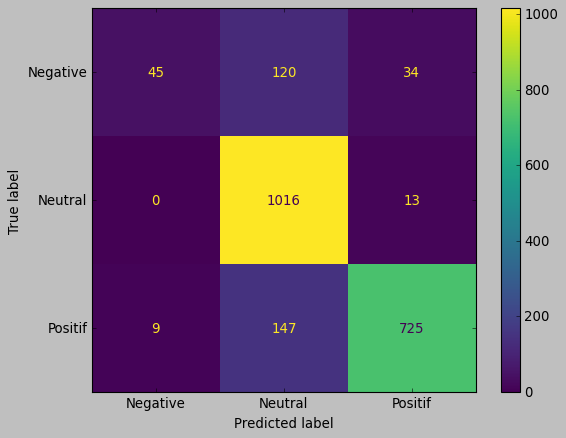

In [147]:
print('LogisticR Model')
lr_model = LogisticRegression()
run_model2(lr_model)

# kesimpulan

dengan melakukan 4 kali percobaan kita bisa mengambil model Linear SVC dengan tingkat akurasi 90% dimana kita tidak perlu melakukan GridCV

#### Finalizing a PipeLine for Deployment on  New Tweets

In [148]:
from sklearn.pipeline import Pipeline

In [149]:
pipe = Pipeline([('tfidf',TfidfVectorizer()),
                 ('svc',LinearSVC())])

In [150]:
pipe.fit(text_df['text'],text_df['sentiment'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc', LinearSVC())])

In [155]:
new_tweet = ['best vaccines']
pipe.predict(new_tweet)

array(['Positif'], dtype=object)

In [157]:
new_tweet = ['this vaccines bad']
pipe.predict(new_tweet)

array(['Negative'], dtype=object)

In [154]:
new_tweet = ['something']
pipe.predict(new_tweet)

array(['Neutral'], dtype=object)

## Great Job!